In [1]:
####
# This is just Transfer
####

In [2]:
## Import Modules 
from iminuit import Minuit as imfit
import numpy as np
from numpy import *
import matplotlib.pyplot as plt
import pyymw16
import gammaALPs
from gammaALPs import core
from gammaALPs.bfields import gmf
import time
import multiprocessing as mp


jansson = gmf.GMF()

# Co-ordinate of sun w.r.t centre of galaxy
d = -8.5

In [3]:
def B_helio(s,l,b):
    
    # Galacto-centric cylindrical co-ordinates in terms of helio-centric co-ordinates
    r = np.sqrt(s**2*cos(b)**2 + d**2 + 2*s*d*cos(l)*cos(b))
    p = arctan2(s*sin(l)*cos(b),(s*cos(l)*cos(b)+d))
    z = s*sin(b)
    
    # Disk, Halo and X field in helio-centric co-ordinates
    B_d = jansson.Bdisk(rho=r, phi=p, z=z) 
    B_h = jansson.Bhalo(rho=r, z=z) 
    B_X = jansson.BX(rho=r,z=z)

    # Components of magnetic field in helio-centric co-ordinates
    B_r = B_d[0][0] + B_h[0][0] + B_X[0][0]
    B_p = B_d[0][1] + B_h[0][1] + B_X[0][1]
    B_z = B_d[0][2] + B_h[0][2] + B_X[0][2]
    
    # Magnetic field in helio-centric co-ordinates    
    B_s = cos(b)*(B_r*cos(l-p)+B_p*sin(l-p)) + B_z*sin(b)
    B_b = sin(b)*(B_r*cos(l-p)+B_p*sin(l-p)) - B_z*cos(b)
    B_l = B_r*sin(p-l) + B_p*cos(p-l)
    
    B_perp = (B_b**2 + B_l**2)**0.5
    Psi = np.arctan2(B_b,B_l)
    
    return B_perp,Psi

In [4]:
# Initialising

spec1 = [1,2,3,4,5,6,7]

psr = ['J0633','J1028','J1418','J1459','J1509','J1741','J1744']

spec1[0] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J0633.7p0632__flux.dat.txt')
spec1[1] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1028.5m5819__flux.dat.txt')
spec1[2] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1418.7m6057__flux.dat.txt')
spec1[3] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1459.4m6053__flux.dat.txt')
spec1[4] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1509.4m5850__flux.dat.txt')
spec1[5] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1741.9m2053__flux.dat.txt')
spec1[6] = np.loadtxt('/home/gautam/Documents/Axion/Codes/Dat/psr_spec_dat/L8Y_J1744.5m1134__flux.dat.txt')

s1 =  np.array([[1.35],[1.42],[1.89],[1.84],[3.37],[0.3],[0.4]])
L1 = (np.array([[205.093],[285.065],[313.325],[317.886],[319.972],[6.422],[14.794]]))
B1 = (np.array([[-0.932],[-0.496],[0.135],[-1.791],[-0.621],[4.907],[9.180]]))

gg = 0

spec = spec1[gg]
s,L,B = s1[gg],L1[gg],B1[gg]

e0 = 1.

bins = 100
step = (s/bins)[0]

path = np.linspace(s[0],0, bins,endpoint = False)

#Initial and Finial States
Rf = np.matrix([[1,0,0],[0,1,0],[0,0,0]])
Ri = 0.5*np.matrix([[1,0,0],[0,1,0],[0,0,0]])

#ne = np.array([0.11 for p in path])   
ne = np.array([pyymw16.calculate_electron_density_lbr(L[0],B[0],p) for p in path])

BP = np.array([B_helio(p,L*np.pi/180,B*np.pi/180) for p in path])
B_perp,psi = np.transpose(BP[:,0])[0],BP[:,1]
psi = np.squeeze(psi)

cp = cos(psi)
sp = sin(psi)

cp2 = cp*cp
sp2 = sp*sp
scp = sp*cp

br = range(bins)

In [5]:
def P_ga(E,m_a,g_ag):
    
    D_ag = 1.52*10**-2*(g_ag*B_perp)
    D_aa = -7.8*10**-2*(m_a**2/E) 
    D_pl = -1.1*10**-7*(ne/E)*1000
    
    # Eigenvalues of mixing matrix
    L1 = D_pl*step
    L2 = 1./2*(D_pl+D_aa-np.sqrt((D_pl-D_aa)**2 + 4*D_ag**2))*step
    L3 = 1./2*(D_pl+D_aa+np.sqrt((D_pl-D_aa)**2 + 4*D_ag**2))*step
    
    alpha = 1./2*arctan2(2.*D_ag,(D_pl-D_aa))
    
    ca = cos(alpha)
    sa = sin(alpha)
    
    ## Computation of probability
    U = np.identity(3)
    el1 = (cos(L1)+1j*sin(L1))
    el2 = (cos(L2)+1j*sin(L2))
    el3 = (cos(L3)+1j*sin(L3))
    
    ca2 = ca**2
    sa2 = sa**2
    sca = sa*ca
    
    sa2sp2 = sa2*sp2
    sa2spcp = sa2*scp
    sacasp = sca*sp
    sa2cp2 = sa2*cp2
    sacacp = sca*cp
    ca2sp2 = ca2*sp2
    ca2spcp = ca2*scp
    ca2cp2 = ca2*cp2
    
    e1cp2 = cp2*el1
    e1scp = scp*el1
    e1sp2 = sp2*el1
    
    e2sa2sp2 = el2*sa2sp2
    e2sa2spcp = el2*sa2spcp
    e2sacasp = el2*sacasp
    e2sa2cp2 = el2*sa2cp2
    e2sacacp = el2*sacacp
    e2ca2 = el2*ca2
    
    e3ca2sp2 = el3*ca2sp2
    e3ca2spcp = el3*ca2spcp
    e3sacasp = el3*sacasp
    e3ca2cp2 = el3*ca2cp2
    e3sacacp = el3*sacacp
    e3sa2 = el3*sa2
    
    T = np.array([[e1cp2 + e2sa2sp2 + e3ca2sp2,e2sa2spcp-e1scp+e3ca2spcp,e3sacasp-e2sacasp],
                  [e3ca2spcp+e2sa2spcp-e1scp,e2sa2cp2+e1sp2+e3ca2cp2,e3sacacp-e2sacacp],
                  [e3sacasp-e2sacasp,e3sacacp-e2sacacp,e2ca2+e3sa2]])

    for i in br: 
        U = np.dot(U,T[:,:,i])
    
    Uc = np.transpose(np.conjugate(U))
    
    return sum(diag(np.dot(np.dot(np.dot(Rf,U),Ri),Uc)))
    

In [6]:
s,l,b = s,L[0],B[0]

def dNdE(E0,E,N0,G,G2,Ec,m_a,g_ag):
    
    if(m_a < 0. ): P = np.array([1. for i in range(np.size(E))])
    else : P = np.array([np.real(P_ga(i,m_a,g_ag)) for i in E])
    
    spectrum =  np.array([N0 * 1e-9 *(E[i]/E0)**(-G) * exp(-(E[i]/Ec)**G2)*P[i]* E[i]**2 *1e+6/624150.934
                          for i in range(np.size(E))])

    return spectrum

In [7]:
sigma = np.sqrt(spec[:,2]**2 + (0.024*spec[:,1])**2)
def sq(N0,G,G2,Ec,m_a,g_ag,E0):
    dnde = dNdE(E0,spec[:,0]/1000,N0,G,G2,Ec,m_a,g_ag)
    chi = (dnde-spec[:,1])/sigma
    s2 = sum(chi**2)
    return s2     

In [8]:
m1 = imfit(sq, N0 = 0.15 , G = 0.5 , G2 = 0.54 , Ec = 0.9, 
          m_a = -1,  g_ag = -1 , E0 = 1,
          error_N0 = 10. , error_G = 10. , fix_G2 = 10. , error_Ec = 1. , fix_E0 = 0.09,
          fix_m_a = 5. , fix_g_ag = 5. , errordef = 1 )
m1.migrad(ncall=1600,resume=True)

------------------------------------------------------------------
| FCN = 10.8                    |     Ncalls=210 (210 total)     |
| EDM = 2.41E-05 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------------------------------
|   | Name |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
------------------------------------------------------------------------------------------
| 0 | N0   |   0.113   |   0.014   |            |            |         |         |       |
| 1 | G    |   1.06    |   0.07    |            |            |         |         |       |
| 2 | G2   |    0.5    |    1.0    |            |            |         |         |  yes  |
| 3 | Ec   |   0.39    |   0.05    |            |            |         |         |       |
| 4 | m_a  |   -1.0    |    1.0    |            |            |         |         |  yes  |
| 5 | g_ag |   -1.0    |    1.0    |            |            |         |         |  yes  |
| 6 | E0   |    1.0    |    1.0    |            |            |         |         |  yes  |
------------------------------------------------------------------------------------------

In [9]:
def main(gALP):
    res = np.array([[0,0,0]])
    
    for mALP in np.linspace(1,9,24):
        m = imfit(sq, N0 = m1.values["N0"] , G2 = 0.54 , G = m1.values["G"] , Ec = m1.values["Ec"], 
          m_a = mALP, g_ag = gALP , E0 = e0 , 
          error_N0 = 10. , error_G = 10. , fix_G2 = 10. , error_Ec = 1. , fix_E0 = 1.,
          fix_m_a = 5. , fix_g_ag = 5. , errordef = 1 )
        m.migrad(ncall=500,resume=True)
        res = np.append(res,[[mALP,gALP,m.fval]],axis=0)

    return res

In [10]:
pool = mp.Pool(processes = 4)

P = pool.map(main,np.linspace(1,1000,50))

pool.close()

/home/gautam/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [11]:
Q = array(P)
X = Q[:,1:,0]
Y = Q[:,1:,1]
Z = Q[:,1:,2]

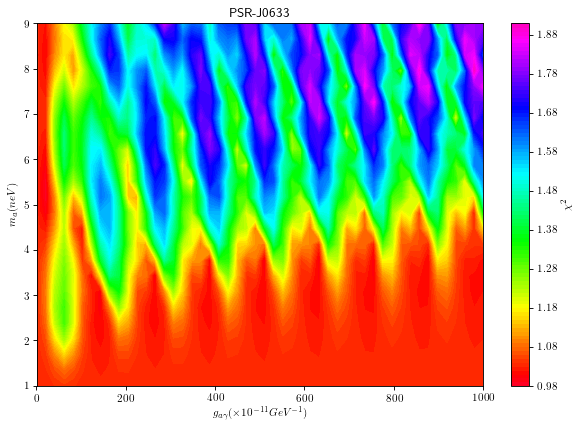

In [12]:
from matplotlib import ticker
plt.rc('text', usetex=True)
plt.figure(figsize=(9, 6), dpi= 80)
cf = plt.contourf(Y,X,log10(Z),100)#,locator=ticker.MultipleLocator())
cb = plt.colorbar(cf)
cb.set_label('$\chi^{2}$')
plt.ylabel('$m_{a} (neV) $')
plt.xlabel('$g_{a\gamma} ( \\times 10^{-11} GeV^{-1})$')
plt.set_cmap('gist_rainbow')
plt.title('PSR-'+psr[gg])

plt.savefig('/home/gautam/Documents/Axion/ICSR/P_'+psr[gg]+'.png')

In [13]:
with open('/home/gautam/Documents/Axion/ICSR/P_'+psr[gg]+'.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(Q.shape))

    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in Q:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.5f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')